**eyetracking during the color change detection task**

imports

In [1]:
import behavior_analysis import *
import eyetrackingTools as eye
from scipy.stats import gaussian_kde

UV='#4B0082'
Green='#6B8E23'
Blue = '#0033cc'

%matplotlib inline
%load_ext autoreload
%autoreload 2 
sns.set_style("white")
import warnings
warnings.filterwarnings('ignore')

#sns.set_palette(['#4d0000','#cc0000','#ff6666','#ffb3b3'])
sns.set_palette(['#d9d9d9','#a6a6a6','#666666','#000000']) # gray scale
sns.set_palette(["#11a421","#00b9d6","#027cfc","#e158d8","#e891ac"])# from http://tools.medialab.sciences-po.fr/iwanthue/; HCL; H [109 - 360]; hard

save_dataframe = False

/Users/administrator/anaconda/lib/python2.7/site-packages/imaging_behavior/core/tifffile.py:2170: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
/Users/administrator/anaconda/lib/python2.7/site-packages/imaging_behavior/core/tifffile.py:2170: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
/Users/administrator/anaconda/lib/python2.7/site-packages/imaging_behavior/core/tifffile.py:2170: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


a few functions for cleaning up the eyetracking data

In [2]:
def fill_from_left(a, x=0):
#from stack exchange
    to_fill = (a == x)
    if a[0] == x:
        a[0]=np.mean(a)
        #raise ValueError("cannot have {} as first element".format(x))
    if to_fill.any():
        lefts = ~to_fill & (np.roll(a, -1) == x)
        fill_from = lefts.cumsum()
        fill_with = a[np.where(lefts)[0]][fill_from - 1]
        a[to_fill] = fill_with[to_fill]
    return a

def clean_eyedata(pupil,cr):  
    pupil_clean = np.zeros(np.shape(pupil));pupil_clean= pupil
    cr_clean = np.zeros(np.shape(cr));cr_clean = cr
    
    last_good_pupil=pupil[0,:]
    last_good_cr   =cr[0,:]
    for frame_no in range(np.shape(pupil)[0]):
        pupil_bad=False;cr_bad=False
        if np.abs(pupil[frame_no,0] - last_good_pupil[0]) > 30\
            or np.abs(pupil[frame_no,1] - last_good_pupil[1]) > 30:
            pupil_bad=True
        if np.abs(cr[frame_no,0] - last_good_cr[0]) > 30\
            or np.abs(cr[frame_no,1] - last_good_cr[1]) > 30:
            pupil_bad=True
#         if cr[frame_no,0] <158. \
#             or 300-cr[frame_no,1] > 100.\
#             or 300-cr[frame_no,1] < 75.\
#             or np.any(np.isnan(cr[frame_no,:])):
            cr_bad=True
            
        if pupil_bad or cr_bad:
            pupil_clean[frame_no,:]= last_good_pupil
            cr_clean[frame_no,:]   = last_good_cr
        else:
            pupil_clean[frame_no,:] = pupil[frame_no,:]
            last_good_pupil         = pupil[frame_no,:]
            cr_clean[frame_no,:]    = cr[frame_no,:]
            last_good_cr            = cr[frame_no,:]
        
    return pupil_clean,cr_clean

def convert_to_degrees(pupil,cr,angle_x,angle_y,image_dimensions=[300,300],mm_per_pixel=.332):
    pupil_degrees = np.zeros((np.shape(pupil)[0],2))
    
    pupil_x = pupil[:,0]
    pupil_y = image_dimensions[1]-pupil[:,1]

    cr_x = cr[:,0]
    cr_y = image_dimensions[1]-cr[:,1]
    
    #measure the distance between the pupil center and the cr center; convert this from pixels to mm, for projection
    #offset the measure so that it is relative to the center of a sphere, by adding the radius of the mouse eye. 
    pupil_x_mm = (pupil_x - cr_x) * mm_per_pixel + 3.32/2.
    pupil_y_mm = (pupil_y - cr_y) * mm_per_pixel + 3.32/2.

    #convert the mm measurements to degrees using basemap
    #3.32 is the the diameter of the mouse eye, in mm
    m=Basemap(projection='ortho',lon_0=0,lat_0=0,rsphere = 3.32/2.)#,llcrnrx=-85,urcrnrx=85,llcrnry=-85,urcrnr=85)
    x, y = m(pupil_x_mm,pupil_y_mm,inverse=True)
    
    #adjust for the position of the cr on the eye, which depends on where the image is taken relative to the eye.
    pupil_degrees[:,0] = x + angle_x
    pupil_degrees[:,1] = y + angle_y
    
    #remove outliers from the projection
    pupil_degrees[np.where(pupil_degrees > 90)]=np.nan
    pupil_degrees[np.where(pupil_degrees < -90)]=np.nan
    return pupil_degrees

# dual eye-tracking, used in Figure S1

set up some constants based on mouse eye measurements and the number of pixels that the eye takes up in the image. for more, see: http://prometheus.med.utah.edu/~marclab/eyes.pdf

In [3]:
left_eye_mm_per_pixel = 3.32/260.
right_eye_mm_per_pixel = 3.32/140.
left_eye_angle_x =  -60.  #degrees  
right_eye_angle_x = 51.2 #degrees
left_eye_angle_y =  10.  #degrees  
right_eye_angle_y = 0. #degrees

load data<br></br>
choose if you want to load from the movies, or load from a dataframe based on the movies


In [4]:
load_movies = False
load_dataframe = True

In [5]:
if load_movies:
    dataR={'n10': np.load(open('/Volumes/DATA2/behavior/M270535/eyetracking/selected/2017-06-06-104659153000-0/results/pupil_params.npy')),
          'p10': np.load(open('/Volumes/DATA2/behavior/M270535/eyetracking/selected/2017-06-06-105334163000-0/results/pupil_params.npy')),
          'p30': np.load(open('/Volumes/DATA2/behavior/M270535/eyetracking/selected/2017-06-06-110628693000-0/results/pupil_params.npy')),
          'p50': np.load(open('/Volumes/DATA2/behavior/M270535/eyetracking/selected/2017-06-06-105931833000-0/results/pupil_params.npy')),
          'n10_cr': np.load(open('/Volumes/DATA2/behavior/M270535/eyetracking/selected/2017-06-06-104659153000-0/results/cr_params.npy')),
          'p10_cr': np.load(open('/Volumes/DATA2/behavior/M270535/eyetracking/selected/2017-06-06-105334163000-0/results/cr_params.npy')),
          'p30_cr': np.load(open('/Volumes/DATA2/behavior/M270535/eyetracking/selected/2017-06-06-110628693000-0/results/cr_params.npy')),
          'p50_cr': np.load(open('/Volumes/DATA2/behavior/M270535/eyetracking/selected/2017-06-06-105931833000-0/results/cr_params.npy')),
          }
    dataL={'n10': np.load(open('/Volumes/DATA2/behavior/M270535/eyetracking/selected/2017-06-06-104659153000-1/results/pupil_params.npy')),
          'p10': np.load(open('/Volumes/DATA2/behavior/M270535/eyetracking/selected/2017-06-06-105334163000-1/results/pupil_params.npy')),
          'p30': np.load(open('/Volumes/DATA2/behavior/M270535/eyetracking/selected/2017-06-06-110628693000-1/results/pupil_params.npy')),
          'p50': np.load(open('/Volumes/DATA2/behavior/M270535/eyetracking/selected/2017-06-06-105931833000-1/results/pupil_params.npy')),
          'n10_cr': np.load(open('/Volumes/DATA2/behavior/M270535/eyetracking/selected/2017-06-06-104659153000-1/results/cr_params.npy')),
          'p10_cr': np.load(open('/Volumes/DATA2/behavior/M270535/eyetracking/selected/2017-06-06-105334163000-1/results/cr_params.npy')),
          'p30_cr': np.load(open('/Volumes/DATA2/behavior/M270535/eyetracking/selected/2017-06-06-110628693000-1/results/cr_params.npy')),
          'p50_cr': np.load(open('/Volumes/DATA2/behavior/M270535/eyetracking/selected/2017-06-06-105931833000-1/results/cr_params.npy')),
           }
if load_dataframe:
    df_r=pd.read_json('df_eye_right.json')
    df_l=pd.read_json('df_eye_left.json')

1. remove points where the fit is bad
    1. remove points that make no sense (i.e., are out of bounds)
    2. remove points where the shape of the pupil is too different from the previous shape (bad fits)
2. convert to visual space 

In [6]:
if load_movies:
    for i,screen_position in enumerate(['n10','p10','p30','p50']):
        dataR[screen_position+'_clean'],dataR[screen_position+'_cr_clean']=clean_eyedata(dataR[screen_position],
                                                                                         dataR[screen_position+'_cr'])
        dataR[screen_position+'_degrees'] =convert_to_degrees(dataR[screen_position+'_clean'],
                                                                                         dataR[screen_position+'_cr_clean'],
                                                                                         angle_x=right_eye_angle_x,
                                                                                         angle_y=right_eye_angle_y,
                                                                                         mm_per_pixel=right_eye_mm_per_pixel)

In [7]:
if load_movies:
    for i,screen_position in enumerate(['n10','p10','p30','p50']):
        dataL[screen_position+'_clean'],dataL[screen_position+'_cr_clean']=clean_eyedata(dataL[screen_position],
                                                                                         dataL[screen_position+'_cr'])
        dataL[screen_position+'_degrees'] =convert_to_degrees(dataL[screen_position+'_clean'],
                                                             dataL[screen_position+'_cr_clean'],
                                                             angle_x=left_eye_angle_x,
                                                             angle_y=left_eye_angle_y,
                                                             mm_per_pixel=left_eye_mm_per_pixel)

put in pandas dataframe for convenience

In [8]:
if load_movies:
    xs=[];ys=[];elevations=[]
    xps=[];yps=[];
    for i,screen_position in enumerate(['n10','p10','p30','p50']):
        ele = [screen_position for i in range(np.shape(dataR[screen_position+'_degrees'][:,0])[0])]
        elevations.extend(ele);
        xs.extend(dataR[screen_position+'_degrees'][:,0]);
        ys.extend(dataR[screen_position+'_degrees'][:,1]);
        xps.extend(dataR[screen_position+'_clean'][:,0]);
        yps.extend(dataR[screen_position+'_clean'][:,1]);
    df_r = pd.DataFrame({'elevation':elevations,
                       'x':xs,
                       'y':ys,
                       'xp':xps,
                       'yp':yps,
        })

    xs=[];ys=[];elevations=[]
    xps=[];yps=[];
    for i,screen_position in enumerate(['n10','p10','p30','p50']):
        ele = [screen_position for i in range(np.shape(dataL[screen_position+'_degrees'][:,0])[0])]
        elevations.extend(ele);
        xs.extend(dataL[screen_position+'_degrees'][:,0]);
        ys.extend(dataL[screen_position+'_degrees'][:,1]);
        xps.extend(dataL[screen_position+'_clean'][:,0]);
        yps.extend(dataL[screen_position+'_clean'][:,1]);
    df_l = pd.DataFrame({'elevation':elevations,
                       'x':xs,
                       'y':ys,
                       'xp':xps,
                       'yp':yps,
        })


In [9]:
coords = [[15,-10],[15,10],[15,30],[15,50]]

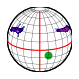

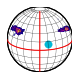

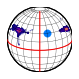

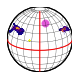

In [10]:
for i,screen_position in enumerate(['n10','p10','p30','p50']):
    plt.figure(figsize=(1.2,1.2))
    df =df_l.dropna()
    x = gaussian_filter1d(np.array(df.x[df.elevation==screen_position]),3)#(fill_from_left(np.nan_to_num(eyedata[:,0])) - 50.) * mm_per_pixel
    y = gaussian_filter1d(np.array(df.y[df.elevation==screen_position]),3)#(np.abs(fill_from_left(np.nan_to_num(eyedata[:,1])) - 210)) * mm_per_pixel
    #compute density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    #project back on to a sphere
    m=Basemap(projection='ortho',lon_0=0,lat_0=20,rsphere = 3.32/2.)#,llcrnrx=-85,urcrnrx=85,llcrnry=-85,urcrnry=85)
    x, y = m(np.array(x),np.array(y))
    m.scatter(x,y,alpha=.3,s=1.,c=z,cmap=plt.cm.plasma)

    df =df_r.dropna()
    x = np.array(df.x[df.elevation==screen_position])#(fill_from_left(np.nan_to_num(eyedata[:,0])) - 50.) * mm_per_pixel
    y = np.array(df.y[df.elevation==screen_position])#(np.abs(fill_from_left(np.nan_to_num(eyedata[:,1])) - 210)) * mm_per_pixel
    #compute density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    #project back on to a sphere
    m=Basemap(projection='ortho',lon_0=0,lat_0=20,rsphere = 3.32/2.)#,llcrnrx=-85,urcrnrx=85,llcrnry=-85,urcrnry=85)
    x, y = m(np.array(x),np.array(y))
    m.drawparallels(np.arange(-90,90,15),linewidth=0.25,dashes=[50,1])
    m.drawmeridians(np.arange(-90,90,15),linewidth=0.25,dashes=[50,1])
    m.drawparallels([0],color='r',dashes=[100,1])
    m.drawmeridians([0],color='r',dashes=[100,1])
    m.scatter(x,y,alpha=.3,s=1.,c=z,cmap=plt.cm.plasma)
    x, y = m(coords[i][0],coords[i][1])
    m.scatter(x,y,c=sns.color_palette()[i],s=7.5**2)

    #plt.gcf().savefig('/Volumes/DATA2/behavior/figures/eyetracking_ortho_dual_'+screen_position+'.eps',format='eps')

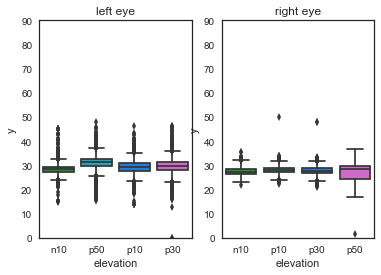

In [11]:
f,ax=plt.subplots(1,2)
sns.boxplot(x='elevation',y='y',data=df_r.dropna(),ax=ax[1],orient='v')
sns.boxplot(x='elevation',y='y',data=df_l.dropna(),ax=ax[0],orient='v')
for axis in ax:
    axis.set_ylim(0,90)
ax[0].set_title('left eye')
ax[1].set_title('right eye')
#plt.gcf().savefig('/Volumes/DATA2/behavior/figures/eyetracking_withdistros_ele.eps',format='eps')

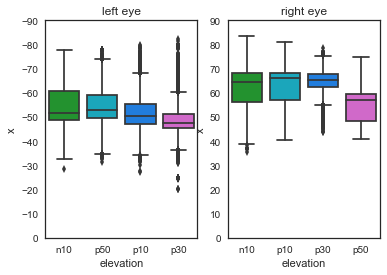

In [12]:
f,ax=plt.subplots(1,2)
sns.boxplot(x='elevation',y='x',data=df_r.dropna(),ax=ax[1])
sns.boxplot(x='elevation',y='x',data=df_l.dropna(),ax=ax[0])
ax[1].set_ylim(0,90)
ax[0].set_ylim(0,-90)
ax[0].set_title('left eye')
ax[1].set_title('right eye')
#plt.gcf().savefig('/Volumes/DATA2/behavior/figures/eyetracking_withdistros_azi.eps',format='eps')

In [18]:
if save_dataframe:
    df_r.to_json('df_eye_right.json')
    df_l.to_json('df_eye_left.json')

<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
# some extra plots from other eyetracking data, not used
#### ...but included after the end in case of interest

load data

In [331]:
data={'n10': np.load(open('/Volumes/DATA2/behavior/M276036/eyetracking/selected/2017-06-02-071849594000-1_n10/results/pupil_params.npy')),
      'p10': np.load(open('/Volumes/DATA2/behavior/M276036/eyetracking/selected/2017-06-02-071849594000-1_p10/results/pupil_params.npy')),
      'p30': np.load(open('/Volumes/DATA2/behavior/M276036/eyetracking/selected/2017-06-02-071849594000-1_p30/results/pupil_params.npy')),
      'p50': np.load(open('/Volumes/DATA2/behavior/M276036/eyetracking/selected/2017-06-02-071849594000-1_p50/results/pupil_params.npy')),
      'n10_cr': np.load(open('/Volumes/DATA2/behavior/M276036/eyetracking/selected/2017-06-02-071849594000-1_n10/results/cr_params.npy')),
      'p10_cr': np.load(open('/Volumes/DATA2/behavior/M276036/eyetracking/selected/2017-06-02-071849594000-1_p10/results/cr_params.npy')),
      'p30_cr': np.load(open('/Volumes/DATA2/behavior/M276036/eyetracking/selected/2017-06-02-071849594000-1_p30/results/cr_params.npy')),
      'p50_cr': np.load(open('/Volumes/DATA2/behavior/M276036/eyetracking/selected/2017-06-02-071849594000-1_p50/results/cr_params.npy')),
      }

based on mouse eye measurements and the number of pixels that the eye takes up in the image:
http://prometheus.med.utah.edu/~marclab/eyes.pdf

In [114]:
mm_per_pixel = 3.32/140.

**TODO: condition data**
1. convert to visual space 
2. remove points where the fit is bad
    1. remove points that make no sense (i.e., are out of bounds)
    2. remove points where the shape of the pupil is too different from the previous shape


In [137]:
for i,screen_position in enumerate(['n10','p10','p30','p50']):
    eyedata = data[screen_position]
    eyedata_cr = data[screen_position+'_cr']
    #1. convert to degrees
    data[screen_position+'_'] = np.zeros(np.shape(eyedata))
    data[screen_position+'_'][:,0]=np.array(data[screen_position][:,0])-np.array(data[screen_position+'_cr'][:,0])
    data[screen_position+'_'][:,1]=np.abs(np.array(data[screen_position][:,1])-np.array(data[screen_position+'_cr'][:,1]))
    #2. remove outliers from bad fitting
    data[screen_position+'_'][:,0][np.where((np.array(data[screen_position+'_'][:,0]) >  20.))[0]]=np.nan 
    data[screen_position+'_'][:,0][np.where((np.array(data[screen_position+'_'][:,0]) < -10.))[0]]=np.nan 
    data[screen_position+'_'][:,0]+=60.
    data[screen_position+'_'][:,1][np.where((np.array(data[screen_position+'_'][:,1]) > 50.))[0]]=np.nan 
    data[screen_position+'_'][:,1][np.where((np.array(data[screen_position+'_'][:,1]) < 25.))[0]]=np.nan 

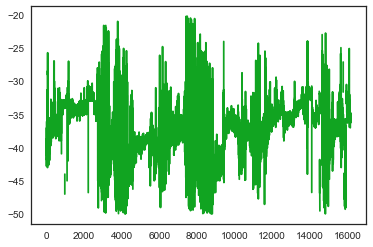

In [135]:
plt.plot(data['p10_'][:,1])

plot all of the points from session, for each elevation

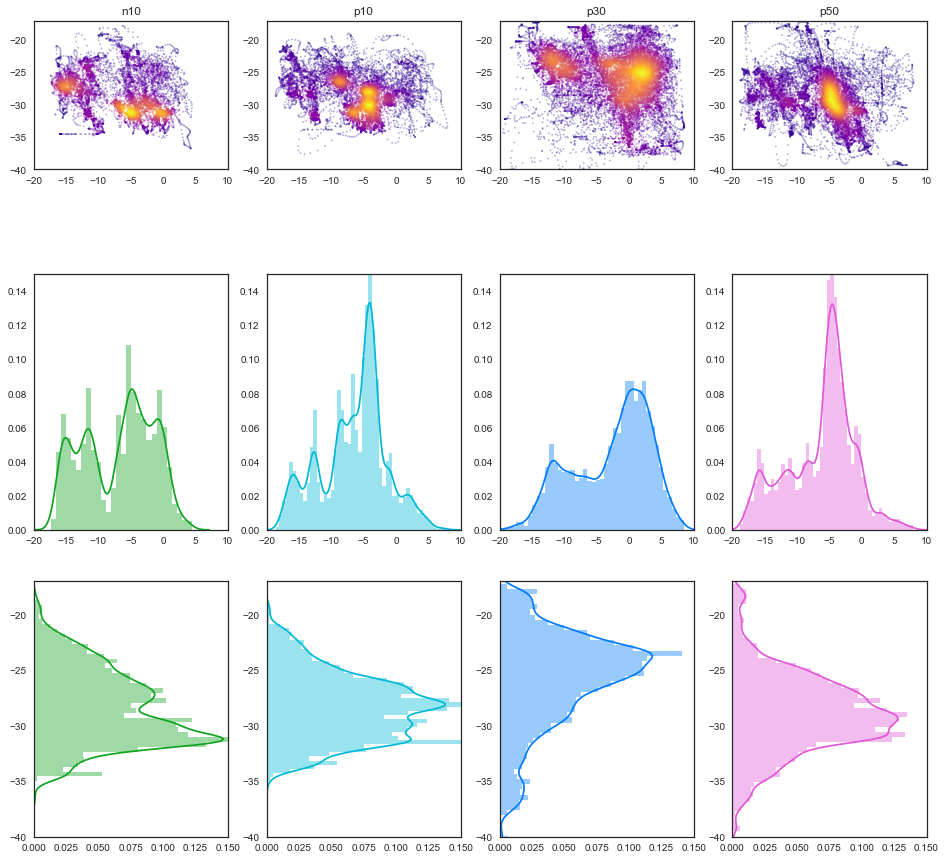

In [139]:
f,ax = plt.subplots(3,4,figsize=(16,16))
xs=[];ys=[];elevations=[]
xps=[];yps=[];
for i,screen_position in enumerate(['n10','p10','p30','p50']):
    eyedata = data[screen_position+'_']
    #eyedata[np.where(np.abs(np.diff(np.nan_to_num(eyedata[:,1])))>100)[0],:] = np.nan
    #eyedata[np.where(np.abs(np.diff(np.nan_to_num(eyedata[:,0])))>100)[0],:] = np.nan
    xp = gaussian_filter1d(fill_from_left(np.nan_to_num(eyedata[:,0]))* mm_per_pixel,3)
    yp = gaussian_filter1d(fill_from_left(np.nan_to_num(eyedata[:,1]))* mm_per_pixel,3)
    xy = np.vstack([xp,yp])
    z = gaussian_kde(xy)(xy)
    
    m=Basemap(projection='ortho',lon_0=0,lat_0=0,rsphere = 337./2.)#,llcrnrx=-85,urcrnrx=85,llcrnry=-85,urcrnr=85)
    x, y = m(xp,yp,inverse=True)
    ax[0][i].scatter(x,y,c=z,cmap=plt.cm.plasma,alpha=0.3,s=2.)
    ax[0][i].set_xlim(-20,10)
    ax[0][i].set_ylim(-40,-17)
    ax[0][i].set_title(screen_position)
    ax[0][i].set_aspect(1.)
    #cleanAxes(ax[0][i],total=True)
    
    sns.distplot(x,ax=ax[1][i],color=sns.color_palette()[i])
    ax[1][i].set_xlim(-20,10)
    ax[1][i].set_ylim(0,0.15)
    
    sns.distplot(y,ax=ax[2][i],color=sns.color_palette()[i],vertical=True)
    ax[2][i].set_ylim(-40,-17)
    ax[2][i].set_xlim(0,0.15)
    
    ele = [screen_position for i in range(np.shape(x)[0])]
    elevations.extend(ele);
    xs.extend(x);ys.extend(y);
    xps.extend(xp);yps.extend(yp);
df = pd.DataFrame({'elevation':elevations,
                   'x':xs,
                   'y':ys,
                   'xp':xps,
                   'yp':yps,
    })
plt.gcf().savefig('/Volumes/DATA2/behavior/figures/eyetracking_planar_withdistros.eps',format='eps')

In [147]:
def plot_mouse_spherical3(coords,projection='ortho',labels=None,radius=15.**2,colors=None,plot_mouse_visual_field=False):
    x = np.array(coords)[:,0]
    y = np.array(coords)[:,1]
    num_points = len(x)
    if colors == None:
        colors = ['k' for i in range(num_points)]
    
    m=Basemap(projection=projection,lon_0=30,lat_0=20,rsphere = 337./2.)#,llcrnrx=-85,urcrnrx=85,llcrnry=-85,urcrnry=85)
    x, y = m(x,y)

    m.scatter(x,y,s=np.ones(len(x))*radius,marker='o',c=colors[:num_points])
    m.drawparallels(np.arange(-90,90,15))
    m.drawmeridians(np.arange(-110,110,15))
    m.drawparallels([0],color='r',dashes=[100,1])
    m.drawmeridians([0],color='r',dashes=[100,1])
    
    if plot_mouse_visual_field:
        x1,y1 = m(-100,-20)
        x2,y2 = m(-100,85)
        x3,y3 = m(100,85)
        x4,y4 = m(100,-20)
        poly = Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],
                               facecolor='green',edgecolor='green',linewidth=3, alpha=0.2)
        plt.gca().add_patch(poly)

In [141]:
coords = [[15,-10],[15,10],[15,30],[15,50]]

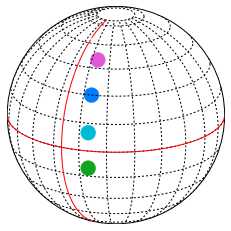

In [149]:
plot_mouse_spherical3(coords,colors=sns.color_palette())
plt.gcf().savefig('/Volumes/DATA2/behavior/figures/spherical_withColors.eps',format='eps')

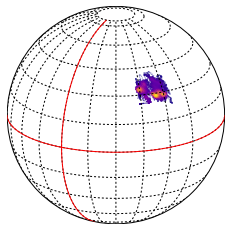

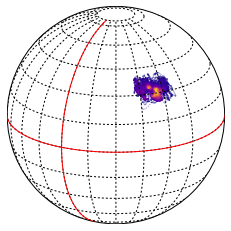

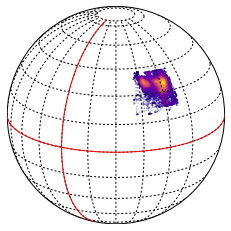

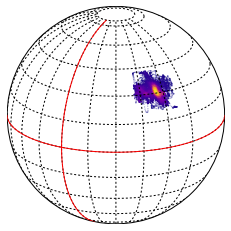

In [151]:
for i,screen_position in enumerate(['n10','p10','p30','p50']):
    x = df.x[df.elevation==screen_position]+60#(fill_from_left(np.nan_to_num(eyedata[:,0])) - 50.) * mm_per_pixel
    y = df.y[df.elevation==screen_position]+60#(np.abs(fill_from_left(np.nan_to_num(eyedata[:,1])) - 210)) * mm_per_pixel
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    plt.figure()
    m=Basemap(projection='ortho',lon_0=30,lat_0=20,rsphere = 337./2.)#,llcrnrx=-85,urcrnrx=85,llcrnry=-85,urcrnry=85)
    x, y = m(np.array(x),np.array(y))
    m.drawparallels(np.arange(-90,90,15))
    m.drawmeridians(np.arange(-90,90,15))
    m.drawparallels([0],color='r',dashes=[100,1])
    m.drawmeridians([0],color='r',dashes=[100,1])
    m.scatter(x,y,alpha=.3,s=1.,c=z,cmap=plt.cm.plasma)
    plt.gcf().savefig('/Volumes/DATA2/behavior/figures/eyetracking_ortho_'+screen_position+'.eps',format='eps')

(0, -90)

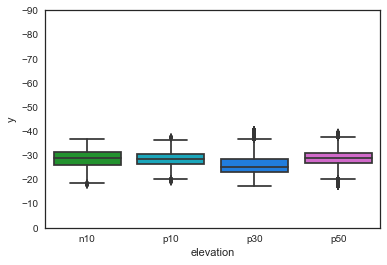

In [102]:
sns.boxplot(x='elevation',y='y',data=df)
plt.gca().set_ylim(0,-90)
#plt.gcf().savefig('/Volumes/DATA2/behavior/figures/eyetracking_planar_withdistros.eps',format='eps')

(0, -90)

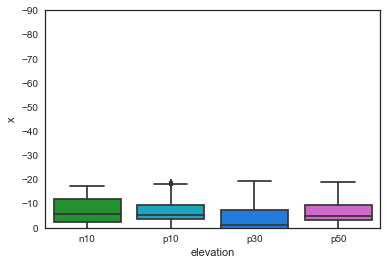

In [34]:
sns.boxplot(x='elevation',y='x',data=df)
plt.gca().set_ylim(0,-90)
#plt.gcf().savefig('/Volumes/DATA2/behavior/figures/eyetracking_planar_withdistros.eps',format='eps')

compare the centers at each elevation, using a multi-dimensional t-test